# Kaggle Challenge : Give Me Some Credit


<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/2551/logos/front_page.png" style="width:200px;height:100px;">

Give Me Some Credit
Improve on the state of the art in credit scoring by predicting the probability that somebody will experience financial distress in the next two years.

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

The goal of this competition is to build a model that borrowers can use to help make the best financial decisions.

Historical data are provided on 250,000 borrowers and 
the prize pool is 5,000 

* 3,000 for first, 
* 1,500 for second and 
* 500 for third.

## Methods

I'm going to implement a ensemble classifier using a couple of methods:

* xgboost
* Random Forest 
* SVM
* PCA
* Artificial Neural Networks

## Scoring Metric: Area Under the Curve (AUC)

Evaluation is done us the AUC or Receiver operating characteristic (ROC), sometimes also referred collectively as 
 Area Under the Receiver Operating Characteristic curve.
 

Y-axis is True Positive Rate (TPR) / Sensitivity
X-axis is the False Positive Rate (FPR) / 1 - specificity

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Sensitivity_and_specificity.svg/700px-Sensitivity_and_specificity.svg.png"  style="height:400px; width:200px">
<caption><center> **ROC AUC**</center></caption><br>

TPR = True positives / Positives 
Positives = True Positives + False Negativs

FPR = False Positives / Negatives
Negatives = True Negatives + False Positives

<img src="http://mchp-appserv.cpe.umanitoba.ca/concept/roc_gif_small.gif">
<caption><center> **Figure 1**</center></caption><br>

Thus having a high AUC curve will be to have a high sensitivity while keeping the false positive rate low

Besides AUC/ROC there's also log

In [3]:
#now lets import the universe
import os
import subprocess

import pandas as pd
import numpy as np 

#import rpy2
#%load_ext rpy2.ipython
# use R's ggplot to plot instead

#machine learning
## xgboost
import xgboost as xgb
from xgboost import XGBClassifier

## sklearn
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion     #
from sklearn_pandas import DataFrameMapper    #
from sklearn_pandas import CategoricalImputer #
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
#score
from sklearn.metrics import roc_auc_score

%connect_info

{
  "shell_port": 35011,
  "iopub_port": 33659,
  "stdin_port": 54849,
  "control_port": 34247,
  "hb_port": 35099,
  "ip": "127.0.0.1",
  "key": "01f2e6c5-3150a01e10667c1221c1d891",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-675dbf3b-12b5-4751-a915-fa846702971e.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [4]:
# Custom class used for this analysis
# Includes download dataset, submit prediction, load data (includes some preprocessing)
from honest import Utils

In [29]:
#Downloads the dataset using Kaggle's API
Utils.downloadData()

# Input data

Below's the description of the input data:

| Variable Name | Description | Type |
| --- | --- | --- |
| SeriousDlqin2yrs  | Person experienced 90 days past due delinquency or worse |  Y/N |
| RevolvingUtilizationOfUnsecuredLines  | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits  | percentage | 
| age | Age of borrower in years  | integer |
| NumberOfTime30-59DaysPastDueNotWorse  | Number of times borrower has been 30-59 days past due but no worse in the last 2 years. | integer |
| DebtRatio | Monthly debt payments, alimony,living costs divided by monthy gross income | percentage |
| MonthlyIncome | Monthly income  | real |
| NumberOfOpenCreditLinesAndLoans | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)  | integer |
| NumberOfTimes90DaysLate | Number of times borrower has been 90 days or more past due. | integer |
| NumberRealEstateLoansOrLines  | Number of mortgage and real estate loans including home equity lines of credit  | integer| 
| NumberOfTime60-89DaysPastDueNotWorse  | Number of times borrower has been 60-89 days past due but no worse in the last 2 years. | integer | 
| NumberOfDependents |  Number of dependents in family excluding themselves (spouse, children etc.) | integer | 

# Exploratory Analysis

## 1. Class imbalance 

In [16]:
X_train, X_test, y_train, y_test, testDF = Utils.loadData(preprocessed=False)
defaulted = np.sum(y_train != 0) + np.sum(y_test != 0)
clean = np.sum(y_train == 0) + np.sum(y_test == 0)

classSep = pd.DataFrame({
    "class":["defaulted","clean"],
    "value":[defaulted, clean]
}, index=[0,1])
classSep

,class,value
0,defaulted,10026
1,clean,139974


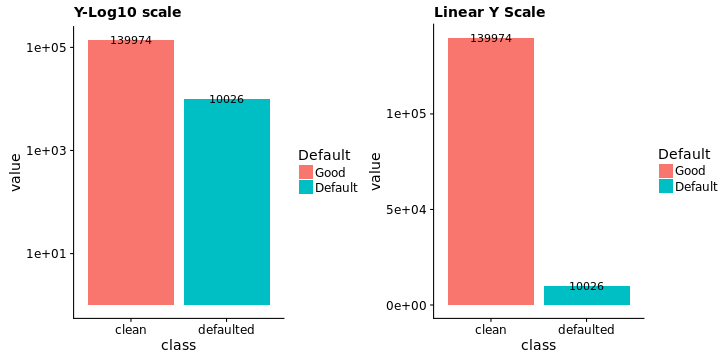

In [19]:
%%R -i classSep -w 10 -h 5 -u in

suppressPackageStartupMessages({
    library(tidyverse)
    library(cowplot)
})

suppressMessages({
    p1 = ggplot(classSep, aes(class, value, fill=class))+ 
        geom_histogram(stat="identity") +
        geom_text(aes(y=value, label=value)) + 
        scale_fill_discrete("Default", labels=c("Good", "Default")) +
        scale_y_log10() + ggtitle("Y-Log10 scale")
     p2 = ggplot(classSep, aes(class, value, fill=class))+ 
        geom_histogram(stat="identity") +
        geom_text(aes(y=value, label=value)) + 
        scale_fill_discrete("Default", labels=c("Good", "Default")) + ggtitle("Linear Y Scale")
    p = plot_grid(p1, p2, nrow=1) 
    print(p)
        })   

In [ ]:
%%R -i X_train 

suppressWarnings({ 
        library(tidyverse)
        library(GGally)
        ggpairs(X_train) %>% ggsave(filename="ggpairs.png", w=30, h=30, dpi=300) 
})

<img src="./ggpairs.png">
<caption><center> **Figure 2**: Pairs plot</center></caption><br>

__Observation:__ A lot of the colunmns do not follow a guassian distribution, lets do some log transformation on it. 

In [ ]:
%%R -i X_train 

suppressWarnings({ 
        library(tidyverse)
        library(GGally)
        X_train %>% select(-DebtRatio, -NumberOfTime30.59DaysPastDueNotWorse, -MonthlyIncome, 
                                    -NumberOfOpenCreditLinesAndLoans, -NumberOfTimes90DaysLate, 
                                    -NumberRealEstateLoansOrLines, -NumberOfTime60.89DaysPastDueNotWorse) %>% 
        ggpairs() %>%
        ggsave(filename="ggpairslog.png", w=30, h=30, dpi=300) 
})

<img src="./ggpairslog.png">
<caption><center> **Figure 2**: Pairs plot</center></caption><br>

Better now, lets try with the different classifiers.

# Model1: XGB

XGB is an ensemble based classifier based on a generalised gradient boosting algorithm. Other packages do exist like lightGBM from microsoft. 

Usually the base classifier is a decision tree, where each tree is built sequentially after the one another, with the new predictor directly addresses the weaknesses in the previous models.

<img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png">

In [22]:
#with log columns
X_train, X_test, y_train, y_test, testDF = loadData(logTransform=True, 
                                                    impute=False, 
                                                    preprocessed=False)
X_train.info()
#There's still some rows with missing values, let us solve this by using an Imputer

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 146722 to 11328
Data columns (total 16 columns):
RevolvingUtilizationOfUnsecuredLines        120000 non-null float64
age                                         120000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse        120000 non-null int64
DebtRatio                                   120000 non-null float64
MonthlyIncome                               96284 non-null float64
NumberOfOpenCreditLinesAndLoans             120000 non-null int64
NumberOfTimes90DaysLate                     120000 non-null int64
NumberRealEstateLoansOrLines                120000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse        120000 non-null int64
NumberOfDependents                          116837 non-null float64
NumberOfTime30-59DaysPastDueNotWorse-log    120000 non-null float64
MonthlyIncome-log                           96284 non-null float64
NumberOfOpenCreditLinesAndLoans-log         120000 non-null float64
NumberOfTimes90

Due the class imbalance we observed earlier, 
lets check if the splitting results in the same class imbalance we see in the training set.

In [23]:
#sanity check
np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test)

(0.06684166666666666, 0.06683333333333333)

Lets account for the missing data using the `Imputer` function by taking the median (median)

In [31]:
weights = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())
weights

13.960728088766986

In [32]:
# Standardised sklearn pipeline with XGB
# Create a boolean mask for categorical columns
# Dont really need cause none of the columns are objects but lets just keep it 
categorical_feature_mask = X_train.dtypes == object

# Get list of categorical column names
categorical_columns = X_train.columns[categorical_feature_mask].tolist()

# Get list of non-categorical column names
non_categorical_columns = X_train.columns[~categorical_feature_mask].tolist()

# Apply numeric imputer (using median/mean) both gives almost the same value
# aka fill the NaNs
numeric_imputation_mapper = DataFrameMapper(
   [([numeric_feature], Imputer(strategy="median")) for numeric_feature in non_categorical_columns],
   input_df=True,
   df_out=True
)

categorical_imputation_mapper = DataFrameMapper(
    [(category_feature, Categorical()) for category_feature in categorical_columns],
    input_df=True,
    df_out=True
)

# Combine the numeric and categorical transformations
numeric_categorical_union = FeatureUnion([
    ("num_mapper", numeric_imputation_mapper),
    ("cat_mapper", categorical_imputation_mapper)
])


# Create full pipeline
pipeline = Pipeline([
   ("featureunion", numeric_imputation_mapper),
   ("clf", xgb.XGBClassifier(max_depth=10, 
                         scale_pos_weight=weights, 
                             gamma=20 #gamma is set high for class imbalance
                            )) #class imbalance
])

In [33]:
# Print avg. AUC
cross_val_scores_cpu = cross_val_score(pipeline, X_train, y_train, scoring="roc_auc", cv=3)
print("3-fold AUC: ", np.mean(cross_val_scores_cpu))

3-fold AUC:  0.8535582293495284


In [34]:
model = pipeline.fit(X_train, y_train)

In [35]:
#model = pipeline.fit(X_train, y_train)
dev = model.predict(X_test)
roc_auc_score(dev, y_test)

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6090251374978501

In [38]:
preds = model.predict(testDF)
Utils.submit(preds, "firstTry_weights_gamma.csv", "firstTry weights gamma")

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



| Dataset | roc_auc | 
| --- | --- | 
| Training set | 0.853  |
| Dev set | 0.609 |
| Test set (public) |0.775060 | 
| Test set (private) | 0.769128 | 

### First try evaluation

We are definitely overfitting the training set. 

There's large variance, 0.85 - 0.609 almost 0.25 difference in ROC

## Tuning

1. Randomised Search
2. Grid Search

In [41]:
gbm_param_grid = {
        'clf__learning_rate': np.arange(0.05, 1, 0.05),
        'clf__max_depth': np.arange(3, 10, 1),
        'clf__n_estimators': np.arange(50, 200, 50)#,
        #'clf__gamma':[5,10,20]
}

grid_roc_auc = GridSearchCV(pipeline,
    param_grid=gbm_param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the estimator
grid_roc_auc.fit(X_train, y_train)

# Compute metrics
print(f'my best score: {grid_roc_auc.best_score_}')
print(grid_roc_auc.best_estimator_)

Fitting 3 folds for each of 399 candidates, totalling 1197 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1197 out of 1197 | elapsed: 15.7min finished


my best score: 0.8649865004930518
Pipeline(memory=None,
     steps=[('featureunion', DataFrameMapper(default=False, df_out=True,
        features=[(['RevolvingUtilizationOfUnsecuredLines'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), (['age'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)),...=0, reg_lambda=1, scale_pos_weight=13.960728088766986,
       seed=None, silent=True, subsample=1))])


In [42]:
preds = grid_roc_auc.predict(X_test)
print(f'AUC: {roc_auc_score(preds, y_test)}')

AUC: 0.598183473983141


/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Interesting with the gamma turned on the AUC is bad

In [43]:
preds = grid_roc_auc.predict(testDF)

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [46]:
#predsSubmit = model.predict(testDF)
Utils.submit(preds, "xgb_straitified_processing_weights_gamma_gridsearch2.csv", "xgb stratified preprocessing weights gamma grid2")

In [44]:
grid_roc_auc.best_estimator_.named_steps['clf']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=20, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=13.960728088766986,
       seed=None, silent=True, subsample=1)

```python
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=20, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=13.960728088766986,
       seed=None, silent=True, subsample=1)
```     
With the grid search

| public | private |  
| --- | --- | 
| 0.790252 | 0.783193 | 



| Dataset | XGB (no tuning) | XGB (with some tuning)|  Random Forest (no tuning) |
| --- | --- |  --- | --- |
| Training set | 0.853  | | |
| Dev set | 0.609 | | |
| Test set (public) |0.775060 | 0.790252 | |
| Test set (private) | 0.769128 | 0.783193 | |


# Random Forest

In [53]:
X_train, X_test, y_train, y_test, testDF = loadData(logTransform=True, 
                                                    impute=False, 
                                                    preprocessed=False)

#Recalculate weights for random forest the input takes a dictionary in this case
weights = np.array(classSep['value']/np.sum(classSep['value']))
classweight = {1:weights[0], 0:weights[1]}
classweight

{0: 0.93316, 1: 0.06684}

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
   ("featureunion", numeric_imputation_mapper),
   ("rf",RandomForestClassifier(random_state=123, n_jobs=-1, class_weight=classweight, n_estimators=400)) #tried 500 gives the same
])

# Perform cross-validation
cross_val_scores = cross_val_score(rf_pipeline, X_train, y_train, scoring="roc_auc", cv=3)
model = pipeline.fit(X_train, y_train)
    
dev = model.predict(X_test)
testScore = roc_auc_score(dev, y_test)
    
print("3-fold AUC: ", np.mean(cross_val_scores))
print("test AUC: ", testScore)

3-fold AUC:  0.8445269407753803
test AUC:  0.6090251374978501


/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [56]:
rfPreds = model.predict(testDF)
#nestimators 500 or 400 gets the same score
Utils.submit(rfPreds, "rf_400.csv", "rf 400")

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RF is doing exactly the same with XGB without tuning

| Dataset | XGB (no tuning) | Random Forest (no tuning) |
| --- | --- |  --- |
| Training set | 0.853  | 0.44|
| Dev set | 0.609 | 0.609 |
| Test set (public) |0.775060 | 0.775060 |
| Test set (private) | 0.769128 | 0.769128 |


_VERY SIMILAR_

This is probably due to the fact that both are tree based ensembles, lets include others to add abit more diversity


## Stacking / ensembling

tried stacking with a metaclassifier (linear regression) doesnt work its, worse. 
tried ensembling (vote) better but the score is still worse than individual predictor. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import EnsembleVoteClassifier

X_train, X_test, y_train, y_test, testDF = loadData(
    logTransform=True, 
    impute=False, 
    preprocessed=False, 
    continuous=False
)

from sklearn.pipeline import make_pipeline

pipe1 = make_pipeline(numeric_imputation_mapper,
                      XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=20, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=13.960728088766986,
       seed=None, silent=True, subsample=1))

pipe2 = make_pipeline(numeric_imputation_mapper,
                      RandomForestClassifier(max_depth=None, random_state=123, class_weight=classweight, n_estimators=400)
                      )


# Initializing models
eclf = EnsembleVoteClassifier(clfs=[pipe1, pipe2],
                              weights=[1, 1], voting='soft')
eclf.fit(X_train, y_train)

In [ ]:
devstack = eclf.predict(X_test)
testScore = roc_auc_score(devstack, y_test)
print(f'test AUC: {testScore}')

In [ ]:
votePreds = eclf.predict(testDF)
submit(votePreds, "xgb_rf_voting2.csv", "xgb rf voting2")

Adding RF and XGB brought the score down: private, public: 
        0.721574, 0.722799


Looked at the discussion forums for some inspiration and came across this guy which wrote 500 lines to create 80 columns, lets use that.

https://www.kaggle.com/c/GiveMeSomeCredit/discussion/31514

In [47]:
X_train, X_test, y_train, y_test, testDF = loadData(logTransform=False, 
                                                    impute=False, 
                                                    preprocessed=True)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 146722 to 11328
Data columns (total 80 columns):
UnknownNumberOfDependents                       120000 non-null int64
UnknownMonthlyIncome                            120000 non-null int64
NoDependents                                    120000 non-null int64
NoIncome                                        120000 non-null int64
ZeroDebtRatio                                   120000 non-null int64
UnknownIncomeDebtRatio                          120000 non-null int64
WeirdRevolvingUtilization                       120000 non-null float64
ZeroRevolvingUtilization                        120000 non-null int64
Log.Debt                                        120000 non-null float64
RevolvingLines                                  120000 non-null int64
HasRevolvingLines                               120000 non-null int64
HasRealEstateLoans                              120000 non-null int64
HasMultipleRealEstateLoans               

In [51]:
params = {
'min_child_weight': 10.0,
'objective': 'binary:logistic',
'max_depth': 5,
'eval_metric': 'auc',
'max_delta_step': 1.8,
'colsample_bytree': 0.4,
'subsample': 0.8,
'eta': 0.025,
'gamma': 0.65,
'num_boost_round' : 391
}
tuned = xgb.XGBClassifier( **params, scale_pos_weight=weights)
tuned.fit(X_train, y_train)
preds = tuned.predict(testDF)
Utils.submit(preds, "discusssion2.csv", "discussionSuperParameters2")

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


BS

Without weights

| Public | Private | 
| --- | --- | 
| 0.599727 | 0.593717 | 

With weights

| Public | Private | 
| --- | --- | 
| 0.791425 | 0.782578 | 

Which is comparable with my own tuning

## Single Layer perceptron

In [41]:
X_train, X_test, y_train, y_test, testDF = Utils.loadData(logTransform=True, 
                                                    impute=True, 
                                                    preprocessed=False)
X_train.info()
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from keras.layers import BatchNormalization
#import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 146722 to 11328
Data columns (total 16 columns):
RevolvingUtilizationOfUnsecuredLines        120000 non-null float64
age                                         120000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse        120000 non-null int64
DebtRatio                                   120000 non-null float64
MonthlyIncome                               120000 non-null float64
NumberOfOpenCreditLinesAndLoans             120000 non-null int64
NumberOfTimes90DaysLate                     120000 non-null int64
NumberRealEstateLoansOrLines                120000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse        120000 non-null int64
NumberOfDependents                          120000 non-null float64
NumberOfTime30-59DaysPastDueNotWorse-log    120000 non-null float64
MonthlyIncome-log                           120000 non-null float64
NumberOfOpenCreditLinesAndLoans-log         120000 non-null float64
NumberOfTimes

In [42]:
# fix random seed for reproducibility
np.random.seed(7)

# split into input (X) and output (Y) variables
X_train_matrix = X_train.as_matrix(columns=[X_train.columns[:]])
X_train_matrix[0,:], X_train_matrix.shape

(array([ 4.98037042e-01,  5.60000000e+01,  1.00000000e+00,  6.05718590e-02,
         5.31500000e+03,  9.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  4.34294477e-09,  3.72550327e+00,
         9.54242510e-01, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00]),
 (120000, 16))

In [48]:
X_test_matrix = X_test.as_matrix(columns=[X_test.columns[:]])

In [43]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight
class_weight_dict = dict(enumerate(class_weight))
class_weight_dict

{0: 0.5358147509800945, 1: 7.480364044383493}

In [44]:
from sklearn.model_selection import StratifiedKFold
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=2000, verbose=0, class_weight=class_weight_dict)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
results = cross_val_score(estimator, X_train_matrix, y_train.values, cv=kfold, )

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator KerasClassifier modif

In [47]:
#print("Accuracy Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy is a bad metric cause of the class imbalance, if i miss the delinquency class I'll still get very high accuracy. 

However KERAS doesnt come naturally with its own `ROC_AUC` scoring.
So I'm going to hack this by using sklearn's randomseSearchCV

In [46]:
param_grid = {}
random_search = RandomizedSearchCV(estimator, 
    param_distributions=param_grid, verbose=1, n_iter=1, scoring="roc_auc")
random_search.fit(X_train_matrix, y_train)
print(f'my best score: {random_search.best_score_}')
print(random_search.best_estimator_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator KerasClassifier modif

my best score: 0.8148518186067275


dev set AUC is 0.81

In [53]:
#estimator.fit(X_train_matrix, y_train.values)
preds = estimator.predict(X_test_matrix)
testScore = roc_auc_score(preds, y_test)
print("test AUC: ", testScore)

test AUC:  0.6018857975090398


In [62]:
testDF_matrix = testDF.as_matrix(columns=[X_test.columns[:]])
preds = estimator.predict(testDF_matrix)
Utils.submit(preds.flatten(), "singleLayer.csv", "single Layer with weights")

Severely overfitting, time to do some feature engineering and ensembling

# Multilayer perceptron

In [63]:
def build_fn(nr_of_layers = 2,
             first_layer_size = 10,
             layers_slope_coeff = 0.8,
             dropout = 0.5,
             activation = "relu",
             weight_l2 = 0.01,
             act_l2 = 0.01,
             input_dim = 16):

    result_model = Sequential()
    result_model.add(Dense(first_layer_size,
                           input_dim = input_dim,
                           activation=activation,
                           W_regularizer= l2(weight_l2),
                           activity_regularizer=l2(act_l2)
                           ))

    current_layer_size = int(first_layer_size * layers_slope_coeff) + 1

    for index_of_layer in range(nr_of_layers - 1):

        result_model.add(BatchNormalization())
        result_model.add(Dropout(dropout))
        result_model.add(Dense(current_layer_size,
                               W_regularizer= l2(weight_l2),
                               activation=activation,
                               activity_regularizer=l2(act_l2)
                               ))

        current_layer_size = int(current_layer_size * layers_slope_coeff) + 1

    result_model.add(Dense(1,
                           activation = "sigmoid",
                           W_regularizer = l2(weight_l2)))

    result_model.compile(optimizer="adam", metrics = ["accuracy"], loss = "binary_crossentropy")

    return result_model

NeuralNet = KerasClassifier(build_fn, )

In [64]:
class_weight_dict

{0: 0.5358147509800945, 1: 7.480364044383493}

In [ ]:
#copied from https://stackoverflow.com/questions/37523882/keras-wrappers-for-scikit-learn-auc-scorer-is-not-working
param_grid = {
    "nr_of_layers" : [2, 3, 4, 5],
    "first_layer_size" : [5, 10, 15],
    "layers_slope_coeff" : [0.4, 0.6, 0.8],
    "dropout" : [0.3, 0.5, 0.8],
    "weight_l2" : [0.01, 0.001, 0.0001],
    "batch_size" : [2000],
    "epochs" : [10]
}
with tf.device('/gpu:0'):
    random_search = RandomizedSearchCV(NeuralNet, 
        param_distributions=param_grid, verbose=0, n_iter=10, scoring="roc_auc", )
    random_search.fit(X_train_matrix, y_train.values,class_weight=class_weight_dict)

/home/uesu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=16, activation="relu", activity_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app
/home/uesu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(7, activation="relu", activity_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`
/home/uesu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="relu", activity_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`
/home/uesu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_regularizer=<keras.reg...)`


Epoch 1/10


In [38]:
print(f'my best score: {random_search.best_score_}')
#print(random_search.best_estimator_)

my best score: 0.49976794983787887


In [ ]:
from keras.callbacks import EarlyStopping
from sklearn.cross_validation import StratifiedKFold
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

#def create_model():
    # create model
model = Sequential()
model.add(Dense(128, input_shape=(16,), activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(256, activation='relu', activity_regularizer=regularizers.l1(10e-5)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
#model.add(Dense(32, activation='relu', activity_regularizer=regularizers.l1(10e-5)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid')) #output
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

nb_epoch = 100
batch_size = 2000

#def train_and_evaluate__model(model, data, label, data_test, label_test):

model.fit(
        X_train_matrix, y_train.values, validation_split=0.1, 
        #callbacks=[early_stopping],
        class_weight=[0.5, 100], 
        epochs = nb_epoch,
        batch_size = batch_size
)
# skf = StratifiedKFold(y_train, n_folds=10, shuffle=True)
# for i, (train, test) in enumerate(skf):
#     print "Running Fold", i+1, "/", n_folds
#     model = None # Clearing the NN.
#     model = create_model()
#     train_and_evaluate_model(model, X_train[train], y_train[train], X_test[test], y_test[test))

In [ ]:
model.summary()

In [ ]:
X_test_matrix.shape, np.sum(y_train.values)

In [ ]:
X_test_matrix = X_test.as_matrix(columns=[X_test.columns[:]])
preds = model.predict(X_train_matrix)
preds
#fail the neural net still thinks everyone is 0
#accuracy = float(np.sum(preds.flatten() == y_test)/y_test.shape[0])
#accuracy

# Autoencoder (Doesn't work)

(didnt work the loss is incredulous)
this is based from the inspiration i got from this post by Veneline Valkov

https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

In [ ]:
X_train, X_test, y_train, y_test, testDF = loadData(logTransform=False, 
                                                    impute=False, 
                                                    preprocessed=True, continuous=True)

In [ ]:
X_train.columns

In [ ]:
%%R -i X_train 

suppressWarnings({ 
        library(tidyverse)
        library(GGally)
        X_train %>% #select(-DebtRatio, -NumberOfTime30.59DaysPastDueNotWorse, -MonthlyIncome, 
#                                    -NumberOfOpenCreditLinesAndLoans, -NumberOfTimes90DaysLate, 
#                                    -NumberRealEstateLoansOrLines, -NumberOfTime60.89DaysPastDueNotWorse) %>% 
        ggpairs() %>%
        ggsave(filename="ggpairs_selected.png", w=30, h=30, dpi=300) 
})

<img src="./ggpairs_selected.png">
<caption><center> **Figure 3**: Pairs plot</center></caption><br>

In [ ]:
defaulting = X_train[y_train == 1]
normal = X_train[y_train == 0]
normal_test = X_test[y_test == 0]

In [ ]:
normal = normal.values
normal_test = normal_test.values
normal_test.shape, normal.shape, 

In [ ]:
#from sklearn.preprocessing import StandardScaler
#data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

input_dim = X_train.shape[1]
encoding_dim = 18 

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(input=input_layer, output=decoder)

In [ ]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint 
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

nb_epoch = 100
batch_size = 1000

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
autoencoder.summary()
checkpointer = ModelCheckpoint(filepath="model2.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [ ]:
history = autoencoder.fit(normal, normal,
                    nb_epoch=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(normal_test, normal_test),
                    verbose=1,
                    callbacks=[tensorboard, checkpointer]).history

#gave up the loss is too fucking big

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');